In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pytz
import plotly.express as px
from csaps import csaps
import plotly.graph_objects as go

# Added src directory to module_path

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.pricing.implied_vola import bs_implied_vola

In [4]:
NANO_IN_SECOND = 1e9
SHIFT_NANO = int((dt.datetime(1970, 1, 1, 0, 0, 0) - dt.datetime(1, 1, 1, 0, 0, 0)).total_seconds()) * NANO_IN_SECOND
TIME_ZONE = pytz.timezone('Asia/Shanghai')

# Load Underlying and Option Data

In [5]:
df_spot = pd.read_csv("data/Case1_UnderlyingData.csv")

In [6]:
def convert(tick):
    result = tick / (24 * 3600 * 1e7)
    return dt.datetime.fromordinal(int(result)) + dt.timedelta(days=result%1) - dt.timedelta(days=365)

In [7]:
df_spot["TS"] = df_spot["RecvTick"].apply(convert)
df_spot["EQUAL"] = df_spot.Bid == df_spot.Ask

In [8]:
df_spot["Timestamp"] = df_spot["TS"].dt.ceil("S")
aggregation_functions = {'Last': 'mean', 'LastVol': 'mean'}
df_spot_aggregated = df_spot.groupby(df_spot['Timestamp']).aggregate(aggregation_functions)
df_spot_aggregated.reset_index(inplace=True)

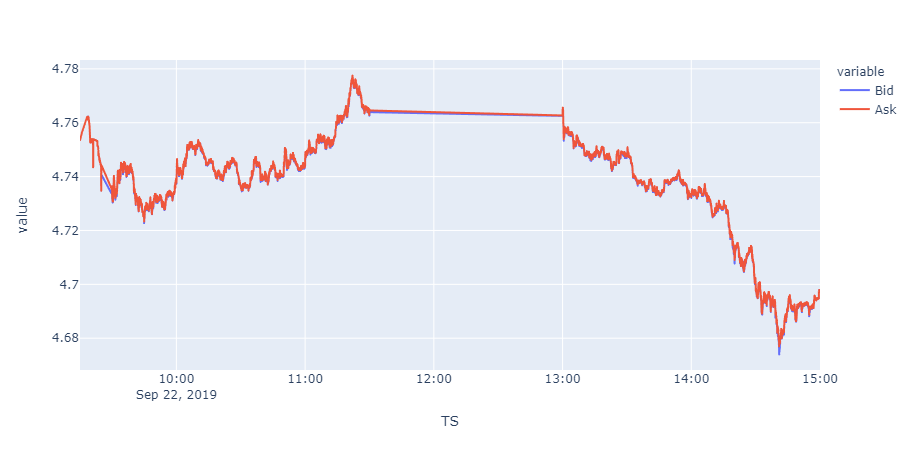

In [9]:
px.line(df_spot, x="TS", y=["Bid", "Ask"])

In [10]:
df_spot.describe()

RecvTick      ExchTick           Bid   BidVol           Ask  \
count  2.320700e+04  2.320700e+04  23207.000000  23207.0  23207.000000   
mean   6.373637e+17  6.373637e+17      4.735725      1.0      4.736023   
std    6.689458e+10  6.689441e+10      0.019898      0.0      0.019861   
min    6.373636e+17  6.373636e+17      4.673947      1.0      4.676940   
25%    6.373637e+17  6.373637e+17      4.731298      1.0      4.731670   
50%    6.373637e+17  6.373637e+17      4.740008      1.0      4.740271   
75%    6.373638e+17  6.373638e+17      4.747738      1.0      4.748021   
max    6.373638e+17  6.373638e+17      4.777392      1.0      4.777529   

        AskVol       RecvTime       ExchTime   ContractId  TradingDay  \
count  23207.0   23207.000000   23207.000000      23207.0     23207.0   
mean       1.0  738056.506926  738056.506920  992999999.0  20200922.0   
std        0.0       0.077424       0.077424          0.0         0.0   
min        1.0  738056.385469  738056.385464  992999999.0  20200922.0   
25%        1.0  738056.433846  738056.433840  992999999.0  20200922.0   
50%        1.0  738056.476525  738056.476519  992999999.0  20200922.0   
75%        1.0  738056.581265  738056.581258  992999999.0  20200922.0   
max        1.0  738056.624997  738056.624991  992999999.0  20200922.0   

               Last  LastVol  Multiplier  
count  23207.000000  23207.0     23207.0  
mean       4.735874      1.0     10000.0  
std        0.019879      0.0         0.0  
min        4.675574      1.0     10000.0  
25%        4.731497      1.0     10000.0  
50%        4.740135      1.0     10000.0  
75%        4.747896      1.0     10000.0  
max        4.777461      1.0     10000.0

In [11]:
df_spot.resample("S", on="TS").Last.mean().tail()

TS
2019-09-22 14:59:55    4.697152
2019-09-22 14:59:56    4.697151
2019-09-22 14:59:57    4.697119
2019-09-22 14:59:58    4.696975
2019-09-22 14:59:59    4.697072
Freq: S, Name: Last, dtype: float64

In [12]:
df_option = pd.read_csv("data/Case1_OptionData.csv")

In [13]:
df_option["TS"] = df_option["RecvTick"].apply(convert)

In [14]:
df_option["Timestamp"] = df_option["TS"].dt.ceil("10S")

In [15]:
df_option.head()

ContractId  TradingDay     Bid     Ask    Last  BidVol  AskVol  LastVol  \
0  2010109470    20200922  0.0700  0.0700  0.0700      11      11        0   
1  2010109480    20200922  0.0159  0.0159  0.0159       4       4        0   
2  2010109470    20200922  0.0700  0.0700  0.0700      12      12        0   
3  2010159480    20200922  0.0612  0.0612  0.0612       1       1        0   
4  2010109490    20200922  0.0017  0.0017  0.0017       1       1        0   

   AveragePrice            RecvTick  ...  BidVol5  Ask5  AskVol5  \
0        0.0700  637363629005359868  ...        0   0.0        0   
1        0.0159  637363629010323657  ...        0   0.0        0   
2        0.0700  637363629035548207  ...        0   0.0        0   
3        0.0612  637363629040631395  ...        0   0.0        0   
4        0.0017  637363629040631644  ...        0   0.0        0   

        RecvTime       ExchTime    Expiry  Strike  OptionType  \
0  738056.385423  738056.385423  20200923     4.7        Call   
1  738056.385429  738056.385429  20200923     4.8        Call   
2  738056.385458  738056.385458  20200923     4.7        Call   
3  738056.385464  738056.385464  20200923     4.8         Put   
4  738056.385464  738056.385464  20200923     4.9        Call   

                          TS           Timestamp  
0 2019-09-22 09:15:00.535982 2019-09-22 09:15:10  
1 2019-09-22 09:15:01.032369 2019-09-22 09:15:10  
2 2019-09-22 09:15:03.554815 2019-09-22 09:15:10  
3 2019-09-22 09:15:04.063141 2019-09-22 09:15:10  
4 2019-09-22 09:15:04.063171 2019-09-22 09:15:10  

[5 rows x 34 columns]

# Group option date by timestamp

In [16]:
group_by_ts = df_option.groupby("Timestamp")

In [17]:
# 2 days in business time
T = 2 / 252
def bid_ask_vol(row):
    row["AskVol"] = bs_implied_vola(row["Strike"], T, spot, row["OptionType"], row["Ask"])
    row["BidVol"] = bs_implied_vola(row["Strike"], T, spot, row["OptionType"], row["Bid"])
    row["MidVol"] = (row["AskVol"] + row["BidVol"]) / 2
    row["HalfSpreadVol"] = (row["AskVol"] - row["BidVol"]) / 2
    return row

In [26]:
def one_timestamp(ts: dt.datetime, spot: float, group: pd.DataFrame, smoothing_factor: float = 0.0):
        group_copy = group.copy()
        group_bid_ask = group_copy.groupby("Strike").apply(lambda g: g.sort_values(by="TS")[["Bid", "Ask", "OptionType"]].tail(1))
        group_bid_ask.reset_index(inplace=True)
        group_bid_ask["HalfSpread"] = (group_bid_ask["Bid"] - group_bid_ask["Ask"]) / 2
        group_bid_ask["Mid"] = (group_bid_ask["Bid"] + group_bid_ask["Ask"]) / 2
        group_bid_ask = group_bid_ask.apply(bid_ask_vol, axis=1)
               
        strikes = group_bid_ask["Strike"].values
        mid_vols = group_bid_ask["MidVol"].values
        weights = 1.0 / group_bid_ask["HalfSpreadVol"]
        sp = csaps(strikes, mid_vols, weights = weights**2, smooth=smoothing_factor)
        group_bid_ask["FittedVol"] = sp(strikes)
        trace_fitted = go.Scatter(
            x=strikes,
            y=sp(strikes),
            mode="lines+markers",
            name="Fitted Vol"
        )

        group_call = group_bid_ask.query("OptionType == 'Call'")
        strikes_call = group_call["Strike"]
        mid_vols_call = group_call["MidVol"]
        half_spread_vols_call = group_call["HalfSpreadVol"]
        trace_call = go.Scatter(
            x=strikes_call,
            y=mid_vols_call,
            error_y=dict(
                type="data",
                array=half_spread_vols_call,
                visible=True
            ),
            mode="markers",
            name="Call Input Vol"
        )
        
        group_put = group_bid_ask.query("OptionType == 'Put'")
        strikes_put = group_put["Strike"]
        mid_vols_put = group_put["MidVol"]
        half_spread_vols_put = group_put["HalfSpreadVol"]
        trace_put = go.Scatter(
            x=strikes_put,
            y=mid_vols_put,
            error_y=dict(
                type="data",
                array=half_spread_vols_put,
                visible=True
            ),
            mode="markers",
            name="Put Input Vol"
        )
        
        data = [trace_call, trace_put, trace_fitted]
        layout = dict(
            width=1000,
            height=600
        )
        fig = go.Figure(data=data, layout=layout)
        return fig

# Fit the first timestamp after current_ts

In [19]:
current_ts = dt.datetime(2019, 9, 22, 14, 45, 1)

In [31]:
# Change smoothing_factor to see the impact of the fit, range [0.0, 1.0]
smoothing_factor = 1.0

Handling timstemp 2019-09-22 14:45:10
current_spot = 4.6922404899300005


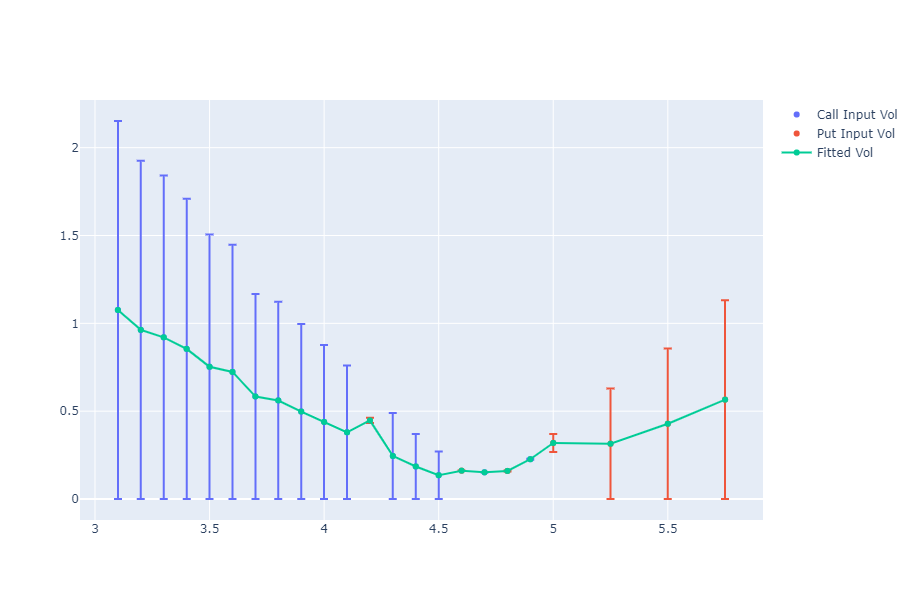

In [32]:
counter = 0
for key, group in group_by_ts:
    if counter >=1:
        continue
    if key > current_ts:
        spot = df_spot_aggregated[df_spot_aggregated["Timestamp"] > key]["Last"].iloc[0]
        print(f"Handling timstemp {key}")
        print(f"current_spot = {spot}")
        fig = one_timestamp(key, spot, group, smoothing_factor=smoothing_factor)
        fig.show()

        counter += 1    